# BIG DATA PROCESSIN PROJECT

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col, isnan, when, count, mean ,stddev, expr, lit,avg

from pyspark.sql.types import StructType, StructField, StringType, DoubleType

###  Create a SparkSession

In [2]:

spark = SparkSession.builder.appName("Happy Countries").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/11 15:09:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

## 1. Data loading and cleaning

### 1.1 Read CSV File into DataFrame with my_schema

### Union datasets

In [4]:
years = [2015, 2016,2017,2018,2019,2020,2021,2022,2023]

In [5]:
# Create file path
csv_file_paths = [f"./data/WHR_{year}.csv" for year in years]

24/11/11 15:10:05 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
df_schema = StructType([
    StructField("Country", StringType(), True),
    StructField("Region", StringType(),True),
    StructField("Happiness_Score",DoubleType(), True),
    StructField("GDP_per_Capita",DoubleType(), True),
    StructField("Social_Support", DoubleType(), True),
    StructField("Healthy_Life_Expectancy", DoubleType(), True),
    StructField("Freedom_to_Make_Life_Choices", DoubleType(), True),
    StructField("Generosity", DoubleType(), True),
    StructField("Perceptions_of_Corruption", DoubleType(), True)

])

In [7]:
# Read csv

dfs = []
for year, path in zip(years, csv_file_paths):
    df = spark.read.csv(path, header=True, schema=df_schema)
    df = df.withColumn("year",lit(year))
    dfs.append(df)

In [8]:
dfs[1].head()

Row(Country='Denmark', Region='Western Europe', Happiness_Score=7.526, GDP_per_Capita=1.44178, Social_Support=1.16374, Healthy_Life_Expectancy=0.79504, Freedom_to_Make_Life_Choices=0.57941, Generosity=0.36171, Perceptions_of_Corruption=0.44453, year=2016)

In [9]:
# Union 
end_df = dfs[0]
for df in dfs[1:]:
    end_df = end_df.unionByName(df)

In [10]:
# Display schema of DataFrame
end_df.show()

+--------------------+--------------------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+
|             Country|              Region|Happiness_Score|GDP_per_Capita|Social_Support|Healthy_Life_Expectancy|Freedom_to_Make_Life_Choices|Generosity|Perceptions_of_Corruption|year|
+--------------------+--------------------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+
|         Switzerland|      Western Europe|          7.587|       1.39651|       1.34951|                0.94143|                     0.66557|   0.29678|                  0.41978|2015|
|             Iceland|      Western Europe|          7.561|       1.30232|       1.40223|                0.94784|                     0.62877|    0.4363|                  0.14145|2015|
|             Denmark|      Western Europe|          7.527|       1.32548| 

In [11]:
# Display schema of DataFrame
end_df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Happiness_Score: double (nullable = true)
 |-- GDP_per_Capita: double (nullable = true)
 |-- Social_Support: double (nullable = true)
 |-- Healthy_Life_Expectancy: double (nullable = true)
 |-- Freedom_to_Make_Life_Choices: double (nullable = true)
 |-- Generosity: double (nullable = true)
 |-- Perceptions_of_Corruption: double (nullable = true)
 |-- year: integer (nullable = false)



### 1.2 Calculating basic statistics

In [12]:
end_df.describe().show()

24/11/11 15:13:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 2:====================================================>      (8 + 1) / 9]

+-------+-----------+--------------+------------------+------------------+-------------------+-----------------------+----------------------------+-------------------+-------------------------+------------------+
|summary|    Country|        Region|   Happiness_Score|    GDP_per_Capita|     Social_Support|Healthy_Life_Expectancy|Freedom_to_Make_Life_Choices|         Generosity|Perceptions_of_Corruption|              year|
+-------+-----------+--------------+------------------+------------------+-------------------+-----------------------+----------------------------+-------------------+-------------------------+------------------+
|  count|       1367|          1367|              1367|              1367|               1367|                   1366|                        1367|               1367|                     1366|              1367|
|   mean|       NULL|          NULL| 5.441086100337234|1.0194221765435258|  1.045334121149232|     0.5840431547291361|          0.4507711995354792|0

### 1.3 Null value analysis

In [13]:
null_counts = end_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in end_df.columns])
null_counts.show()

+-------+------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+
|Country|Region|Happiness_Score|GDP_per_Capita|Social_Support|Healthy_Life_Expectancy|Freedom_to_Make_Life_Choices|Generosity|Perceptions_of_Corruption|year|
+-------+------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+
|      0|     0|              0|             0|             0|                      1|                           0|         0|                        1|   0|
+-------+------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+



In [14]:
df_cleaned= end_df.dropna(subset=["Healthy_Life_Expectancy","Perceptions_of_Corruption"])

In [15]:
df_cleaned.count()

1365

## 2. Exploratory Data Analysis (EDA)

### 2.1 Distribution of Happiness

In [16]:
happiness_stats = df_cleaned.select(
    mean(col("Happiness_Score")).alias("mean"),
    stddev(col("Happiness_Score")).alias("stddev"),
    expr("percentile_approx(Happiness_Score, 0.25)").alias("Q1"),
    expr("percentile_approx(Happiness_Score, 0.5)").alias("median"),
    expr("percentile_approx(Happiness_Score, 0.75)").alias("Q3")
)

happiness_stats.show()

+-----------------+-----------------+-----+------+-----+
|             mean|           stddev|   Q1|median|   Q3|
+-----------------+-----------------+-----+------+-----+
|5.440500145905494|1.118053079366458|4.596|  5.44|6.255|
+-----------------+-----------------+-----+------+-----+



## 2.2 Correlation of factors with happiness

To find the correlation between each factor and the Happiness_Score, we will use the correlation function in PySpark for each factor. Here we assume that there are several columns of factors, for example: GDP_Per_Capita, Social_Support, Life_Expectancy, etc.

In [17]:
from pyspark.sql.functions import corr
from pyspark.sql import Row

In [18]:
# List of factors we want to correlate with happines_score
factor_columns = ["GDP_per_Capita","Social_Support","Healthy_Life_Expectancy","Freedom_to_Make_Life_Choices","Generosity","Perceptions_of_Corruption"]

In [19]:
correlation_data = []

In [20]:
# Calculate the correlation of each factor
for factor in factor_columns:
    correlation = df_cleaned.select(corr("Happiness_Score",factor).alias("correlation")).collect()[0]["correlation"]
    print(f"Correlation between Happiness_Score and {factor}: {correlation}")
    correlation_data.append(Row(Factor=factor,Correlation=correlation))

Correlation between Happiness_Score and GDP_per_Capita: 0.723784949432059
Correlation between Happiness_Score and Social_Support: 0.6498436290451899
Correlation between Happiness_Score and Healthy_Life_Expectancy: 0.682479558984849
Correlation between Happiness_Score and Freedom_to_Make_Life_Choices: 0.5709017429407508
Correlation between Happiness_Score and Generosity: 0.08210993118693721
Correlation between Happiness_Score and Perceptions_of_Corruption: 0.4149541173536084


In [21]:
correlation_df = spark.createDataFrame(correlation_data)
correlation_df = correlation_df.orderBy("Correlation", ascending=False)
correlation_df.show()

+--------------------+-------------------+
|              Factor|        Correlation|
+--------------------+-------------------+
|      GDP_per_Capita|  0.723784949432059|
|Healthy_Life_Expe...|  0.682479558984849|
|      Social_Support| 0.6498436290451899|
|Freedom_to_Make_L...| 0.5709017429407508|
|Perceptions_of_Co...| 0.4149541173536084|
|          Generosity|0.08210993118693721|
+--------------------+-------------------+



### 2.3 Annual and Regional Trends

In [23]:
# Average Happiness_Score by Year
annual_trend = df_cleaned.groupBy("year").agg(mean("Happiness_Score").alias("AVG_Happiness_Score"))
annual_trend.orderBy("AVG_Happiness_Score",ascending=False).show()
                                             

+----+-------------------+
|year|AVG_Happiness_Score|
+----+-------------------+
|2022|   5.55357534246575|
|2023|  5.544441176470589|
|2021|  5.532838926174494|
|2020|   5.47323986284967|
|2019|  5.407096153846153|
|2016|  5.382184713375795|
|2015| 5.3757341772151905|
|2018|  5.366896774193549|
|2017|  5.354019355774192|
+----+-------------------+



In [24]:
# Average Happiness_Score by Region
region_trend = df_cleaned.groupBy("Region").agg(mean("Happiness_Score").alias("AVG_Happiness_Score"))
region_trend.orderBy("AVG_Happiness_Score",ascending=False).show(truncate=False)

+----------------------------------+-------------------+
|Region                            |AVG_Happiness_Score|
+----------------------------------+-------------------+
|North America and ANZ             |7.176058332472223  |
|Western Europe                    |6.811460638909575  |
|Latin America and Caribbean       |5.993860526805262  |
|East Asia                         |5.732149987592593  |
|Commonwealth of Independent States|5.639040905886364  |
|Central and Eastern Europe        |5.585753270855141  |
|Southeast Asia                    |5.3704287529       |
|Middle East and North Africa      |5.26798553601258   |
|Africa                            |5.057              |
|South Asia                        |4.473263924868853  |
|Sub-Saharan Africa                |4.288796142305638  |
+----------------------------------+-------------------+



## 2.4 Relevant Groupings and Filtering

In [29]:
# Grouping by region and calculation of average Happiness_Score and other factors 
region_summary = df_cleaned.groupBy("Region").agg(
    avg("Happiness_Score").alias("AVG_Happiness_Score"),
    avg("GDP_per_Capita").alias("AVG_GDP_per_Capita"),
    avg("Social_Support").alias("AVG_Social_Support"),
    avg("Healthy_Life_Expectancy").alias("AVG_Healthy_Life_Expectancy"),
    avg("Freedom_to_Make_Life_Choices").alias("AVG_Freedom"),
    avg("Generosity").alias("AVG_Generosity"),
    avg("Perceptions_of_Corruption").alias("AVG_Perceptions_of_Corruption")
)

region_summary.orderBy("AVG_Happiness_Score",ascending=False).show()

+--------------------+-------------------+-------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|              Region|AVG_Happiness_Score| AVG_GDP_per_Capita|AVG_Social_Support|AVG_Healthy_Life_Expectancy|        AVG_Freedom|     AVG_Generosity|AVG_Perceptions_of_Corruption|
+--------------------+-------------------+-------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|North America and...|  7.176058332472223| 1.5018248203888886|1.3518091635555554|         0.8178462977222222| 0.6059892894444444|0.33619929672222226|           0.3067956118888889|
|      Western Europe|  6.811460638909575| 1.4904419756648937|1.2974117135797874|         0.8435619392446807| 0.5480937489414893|0.23022084629787232|          0.24835307204787233|
|Latin America and...|  5.993860526805262| 1.0168062146210526|1.1473719096210526|         0.64776851

In [30]:
# Grouping by Country and calculation of average Happiness_Score and other factors 
country_summary = df_cleaned.groupBy("Country").agg(
    avg("Happiness_Score").alias("AVG_Happiness_Score"),
    avg("GDP_per_Capita").alias("AVG_GDP_per_Capita"),
    avg("Social_Support").alias("AVG_Social_Support"),
    avg("Healthy_Life_Expectancy").alias("AVG_Healthy_Life_Expectancy"),
    avg("Freedom_to_Make_Life_Choices").alias("AVG_Freedom"),
    avg("Generosity").alias("AVG_Generosity"),
    avg("Perceptions_of_Corruption").alias("AVG_Perceptions_of_Corruption")
)

country_summary.orderBy("AVG_Happiness_Score",ascending=False).show()

+--------------+-------------------+------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|       Country|AVG_Happiness_Score|AVG_GDP_per_Capita|AVG_Social_Support|AVG_Healthy_Life_Expectancy|        AVG_Freedom|     AVG_Generosity|AVG_Perceptions_of_Corruption|
+--------------+-------------------+------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|       Finland|  7.662744438666666|1.4773323815555555| 1.402296958888889|         0.8201610083333333| 0.6632219552222223|0.17862035722222216|           0.4466920894444445|
|       Denmark|  7.579733297555555|1.5238435041111111|1.4045434216666668|         0.8202864545555556|  0.659315179888889|0.27124154277777784|           0.4649033773333333|
|       Iceland|  7.522277788777779|1.5114571808888888|1.4581812771111113|         0.8581739475555555| 0.6562392647777777| 0.3634389387

In [31]:
# Grouping by Country and Region and calculation of average Happiness_Score and other factors 
region_country_summary = df_cleaned.groupBy("Region","Country").agg(
    avg("Happiness_Score").alias("AVG_Happiness_Score"),
    avg("GDP_per_Capita").alias("AVG_GDP_per_Capita"),
    avg("Social_Support").alias("AVG_Social_Support"),
    avg("Healthy_Life_Expectancy").alias("AVG_Healthy_Life_Expectancy"),
    avg("Freedom_to_Make_Life_Choices").alias("AVG_Freedom"),
    avg("Generosity").alias("AVG_Generosity"),
    avg("Perceptions_of_Corruption").alias("AVG_Perceptions_of_Corruption")
)

region_country_summary.orderBy("AVG_Happiness_Score",ascending=False).show(truncate=False)

+----------------------------+--------------+-------------------+------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|Region                      |Country       |AVG_Happiness_Score|AVG_GDP_per_Capita|AVG_Social_Support|AVG_Healthy_Life_Expectancy|AVG_Freedom        |AVG_Generosity     |AVG_Perceptions_of_Corruption|
+----------------------------+--------------+-------------------+------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|Western Europe              |Finland       |7.662744438666666  |1.4773323815555555|1.402296958888889 |0.8201610083333333         |0.6632219552222223 |0.17862035722222216|0.4466920894444445           |
|Western Europe              |Denmark       |7.579733297555555  |1.5238435041111111|1.4045434216666668|0.8202864545555556         |0.659315179888889  |0.27124154277777784|0.4649033773333333   

### 3. Clustering with MLlib in PySpark (K-means)

### 3.1. Feature selection and standardization

In [32]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [33]:
# Select columns
feature_columns = ["GDP_per_Capita", "Social_Support", "Healthy_Life_Expectancy", "Freedom_to_Make_Life_Choices"]
#Create assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [34]:
# Combines the columns into a single feature vector 
df_features = assembler.transform(df_cleaned)

### 3.2. Normalization

In [35]:
scaler = StandardScaler(inputCol="features",outputCol="scaled_features")
scaler_model = scaler.fit(df_features)
df_scaled =scaler_model.transform(df_features)

### 3.3. K-means application

In [37]:
kmeans = KMeans(k=3,featuresCol="scaled_features",predictionCol="cluster")
model = kmeans.fit(df_scaled)

In [38]:
# Cluster prediction
df_clustered = model.transform(df_scaled)

In [39]:
df_clustered.select("Country","Region","cluster").show()

+--------------------+--------------------+-------+
|             Country|              Region|cluster|
+--------------------+--------------------+-------+
|         Switzerland|      Western Europe|      0|
|             Iceland|      Western Europe|      0|
|             Denmark|      Western Europe|      0|
|              Norway|      Western Europe|      0|
|              Canada|North America and...|      0|
|             Finland|      Western Europe|      0|
|         Netherlands|      Western Europe|      0|
|              Sweden|      Western Europe|      0|
|         New Zealand|North America and...|      0|
|           Australia|North America and...|      0|
|              Israel|Middle East and N...|      2|
|          Costa Rica|Latin America and...|      0|
|             Austria|      Western Europe|      0|
|              Mexico|Latin America and...|      2|
|       United States|North America and...|      0|
|              Brazil|Latin America and...|      2|
|          L

### 3.4: Cluster interpretation

In [40]:
from pyspark.sql import functions as F

In [41]:
df_clustered.groupBy("cluster").agg(
    F.mean("GDP_per_Capita").alias("AVG_GDP_per_Capita"),
    F.mean("Social_Support").alias("AVG_Social_Support"),
    F.mean("Healthy_Life_Expectancy").alias("AVG_Healthy_Life_Expectancy"),
    F.mean("Freedom_to_Make_Life_Choices").alias("AVG_Freedom_to_Make_Life_Choices")
).show()

+-------+------------------+------------------+---------------------------+--------------------------------+
|cluster|AVG_GDP_per_Capita|AVG_Social_Support|AVG_Healthy_Life_Expectancy|AVG_Freedom_to_Make_Life_Choices|
+-------+------------------+------------------+---------------------------+--------------------------------+
|      1| 0.517410345427481|0.7032292063460559|         0.3025468161221374|              0.3597468699847329|
|      2|1.0233307286354167|1.0868165649541666|         0.6505372696166665|             0.39068701874583334|
|      0|1.4141648370670734|1.2781416958109753|         0.7438499211544716|              0.5825080098841464|
+-------+------------------+------------------+---------------------------+--------------------------------+



## 3.5 Visualization

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
# Converting PySpark DataFrame to pandas for visualization
df_clustered_pandas = df_clustered.toPandas()


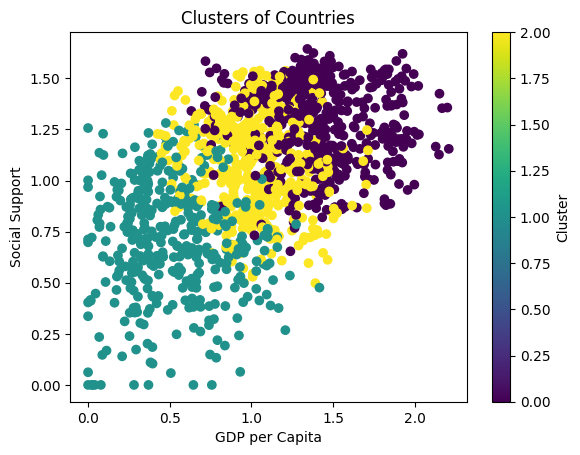

In [44]:
# create a scatter plot
plt.scatter(df_clustered_pandas["GDP_per_Capita"],df_clustered_pandas["Social_Support"],
            c=df_clustered_pandas["cluster"],cmap="viridis")
plt.xlabel('GDP per Capita')
plt.ylabel('Social Support')
plt.title('Clusters of Countries')
plt.colorbar(label='Cluster')
plt.show()

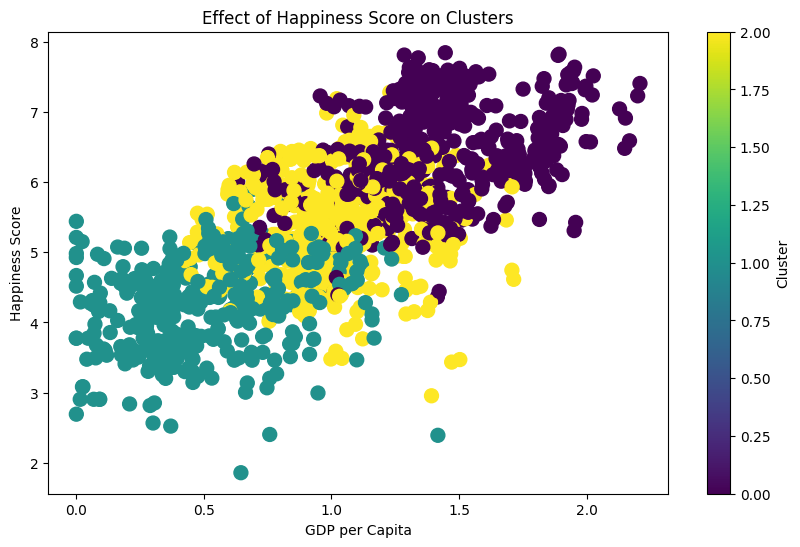

In [45]:
plt.figure(figsize=(10, 6))

# create a scatter plot happiness_score and GDP_per_capita
plt.scatter(df_clustered_pandas['GDP_per_Capita'], 
            df_clustered_pandas['Happiness_Score'], 
            c=df_clustered_pandas['cluster'], cmap='viridis', s=100)


plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Score')
plt.title('Effect of Happiness Score on Clusters')

plt.colorbar(label='Cluster')

plt.show()

The cluster with the happiest countries by gdp_per_capita is 2.

In [46]:
df_cluster_2_pandas = df_clustered_pandas[df_clustered_pandas['cluster'] == 2]

df_cluster_2_pandas.head()

,Country,Region,Happiness_Score,GDP_per_Capita,Social_Support,Healthy_Life_Expectancy,Freedom_to_Make_Life_Choices,Generosity,Perceptions_of_Corruption,year,features,scaled_features,cluster
10,Israel,Middle East and North Africa,7.278,1.22857,1.22393,0.91387,0.41319,0.33172,0.07785,2015,"[1.22857, 1.22393, 0.91387, 0.41319]","[2.7115656486582678, 3.694901302736398, 3.7270...",2
13,Mexico,Latin America and Caribbean,7.187,1.02054,0.91451,0.81444,0.48181,0.14074,0.21312,2015,"[1.02054, 0.91451, 0.81444, 0.48181]","[2.2524245318392184, 2.7607985672101045, 3.321...",2
15,Brazil,Latin America and Caribbean,6.983,0.98124,1.23287,0.69702,0.49049,0.14574,0.17521,2015,"[0.98124, 1.23287, 0.69702, 0.49049]","[2.165685860056357, 3.7218901155332595, 2.8427...",2
22,Venezuela,Latin America and Caribbean,6.810,1.04424,1.25596,0.72052,0.42908,0.05841,0.11069,2015,"[1.04424, 1.25596, 0.72052, 0.42908]","[2.3047325858151426, 3.791596120844171, 2.9385...",2
26,Chile,Latin America and Caribbean,6.670,1.10715,1.12447,0.85857,0.44132,0.33363,0.12869,2015,"[1.10715, 1.12447, 0.85857, 0.44132]","[2.4435806733942727, 3.3946432131641497, 3.501...",2


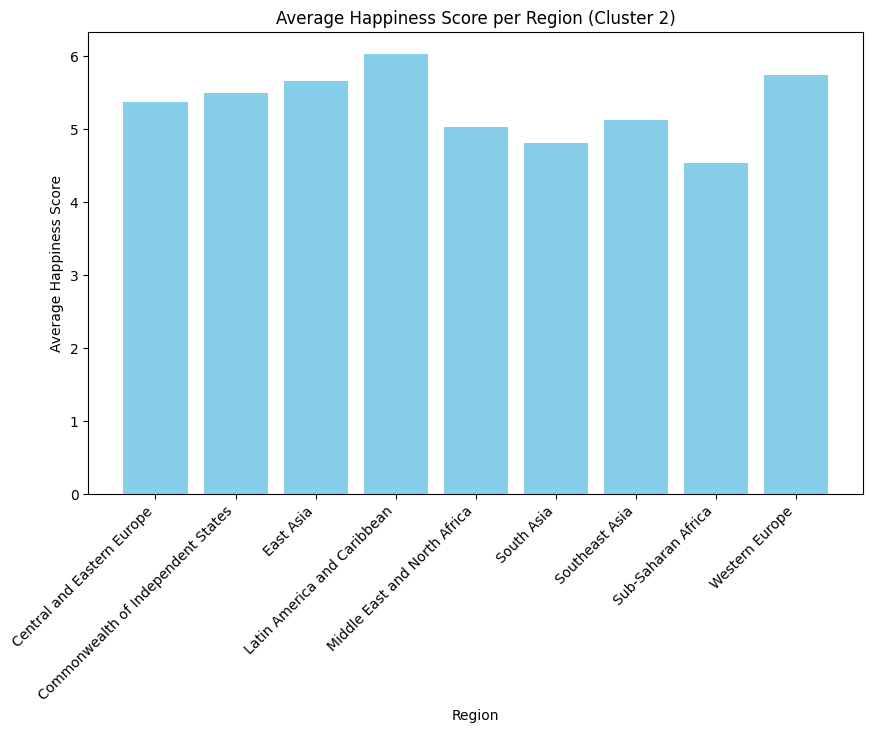

In [47]:
# AVG by región and mean of happiness_score
region_avg_happiness = df_cluster_2_pandas.groupby('Region')['Happiness_Score'].mean().reset_index()

# Create 
plt.figure(figsize=(10, 6))
plt.bar(region_avg_happiness['Region'], region_avg_happiness['Happiness_Score'], color='skyblue')

# Title
plt.xlabel('Region')
plt.ylabel('Average Happiness Score')
plt.title('Average Happiness Score per Region (Cluster 2)')
plt.xticks(rotation=45, ha='right')

# Show
plt.show()

In [48]:
region_avg_happiness

,Region,Happiness_Score
0,Central and Eastern Europe,5.374155
1,Commonwealth of Independent States,5.496617
2,East Asia,5.654358
3,Latin America and Caribbean,6.036357
4,Middle East and North Africa,5.024644
5,South Asia,4.805524
6,Southeast Asia,5.121374
7,Sub-Saharan Africa,4.530747
8,Western Europe,5.739736


Conclusion: North America and ANZ and Western Europe are the happiest areas in this dataset, as they have the highest happiness scores.

## 4. Predict Model
### 4.1. Select the columns of characteristics and the target.

In [50]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [49]:
feature_columns = ["GDP_per_Capita", "Social_Support", "Healthy_Life_Expectancy", "Freedom_to_Make_Life_Choices"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_features = assembler.transform(df_cleaned).select("features", "Happiness_Score")

### 4.2. Divide the data into training and test sets (80%-20%).

In [51]:
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=123)

### 4.3 Creates and fits the regression model

In [52]:
lr = LinearRegression(featuresCol="features", labelCol="Happiness_Score")
lr_model = lr.fit(train_data)

24/11/11 16:01:19 WARN Instrumentation: [e39bb524] regParam is zero, which might cause numerical instability and overfitting.
24/11/11 16:01:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


### 4.4 Predictions in the test set


In [53]:
predictions = lr_model.transform(test_data)

### 4.5 Model evaluation using the mean squared error (MSE)

In [54]:
evaluator = RegressionEvaluator(labelCol="Happiness_Score", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print(f"Error Cuadrático Medio (MSE): {mse}")

Error Cuadrático Medio (MSE): 0.34875311389055863


### 4.6 Additional model information (coefficients and intercept)

In [55]:
print(f"Coeficientes: {lr_model.coefficients}")
print(f"Intercepto: {lr_model.intercept}")

Coeficientes: [0.7812969946992419,0.6489954682206707,1.4467430109159378,1.9711535120856587]
Intercepto: 2.233414333535538


In [56]:
spark.stop()